In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os

# ==================== CONFIG ====================
DATA_DIR = 'C:/Users/pc/Desktop/Attention/dataset_split'
BATCH_SIZE = 32
IMG_SIZE = 96
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_PATH = 'C:/Users/pc/Desktop/Attention/densenet169_2class.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== CUSTOM DENSENET169 ====================
class DenseNet169_Base(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet169_Base, self).__init__()
        self.backbone = models.densenet169(pretrained=True)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ==================== DATASET ====================
class BacteriaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        label_map = {'negative': 0, 'positive': 1}
        for label_name, label_id in label_map.items():
            folder = os.path.join(root_dir, label_name)
            if not os.path.exists(folder):
                continue
            for img_name in os.listdir(folder):
                self.samples.append((os.path.join(folder, img_name), label_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ==================== TRANSFORMS ====================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==================== DATA LOADERS ====================
train_data = BacteriaDataset(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_data = BacteriaDataset(os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
test_data = BacteriaDataset(os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ==================== CLASS WEIGHTS ====================
label_counts = [0, 0]
for _, label in train_data:
    label_counts[label] += 1

total_samples = sum(label_counts)
class_weights = torch.tensor([
    total_samples / (2 * count) if count > 0 else 0.0 for count in label_counts
], dtype=torch.float).to(device)

# ==================== TRAINING FUNCTION ====================
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), MODEL_PATH)
    print("✅ Final model saved successfully!")

# ==================== RUN TRAINING ====================
model = DenseNet169_Base(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, EPOCHS)


E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
E:\anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.2462, Train Acc: 90.05% | Val Loss: 0.0301, Val Acc: 100.00%
Epoch 2/20 | Train Loss: 0.0195, Train Acc: 99.52% | Val Loss: 0.0102, Val Acc: 100.00%
Epoch 3/20 | Train Loss: 0.0079, Train Acc: 99.84% | Val Loss: 0.0038, Val Acc: 100.00%
Epoch 4/20 | Train Loss: 0.0072, Train Acc: 99.68% | Val Loss: 0.0035, Val Acc: 100.00%
Epoch 5/20 | Train Loss: 0.0038, Train Acc: 100.00% | Val Loss: 0.0030, Val Acc: 100.00%
Epoch 6/20 | Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.0032, Val Acc: 100.00%
Epoch 7/20 | Train Loss: 0.0066, Train Acc: 99.84% | Val Loss: 0.0033, Val Acc: 100.00%
Epoch 8/20 | Train Loss: 0.0033, Train Acc: 100.00% | Val Loss: 0.0009, Val Acc: 100.00%
Epoch 9/20 | Train Loss: 0.0014, Train Acc: 100.00% | Val Loss: 0.0009, Val Acc: 100.00%
Epoch 10/20 | Train Loss: 0.0011, Train Acc: 100.00% | Val Loss: 0.0008, Val Acc: 100.00%
Epoch 11/20 | Train Loss: 0.0007, Train Acc: 100.00% | Val Loss: 0.0006, Val Acc: 100.00%
Epoch 12/20 | Train Loss

E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Classification Report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       104
    positive       1.00      1.00      1.00       189

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293

🧮 Confusion Matrix:
[[104   0]
 [  0 189]]


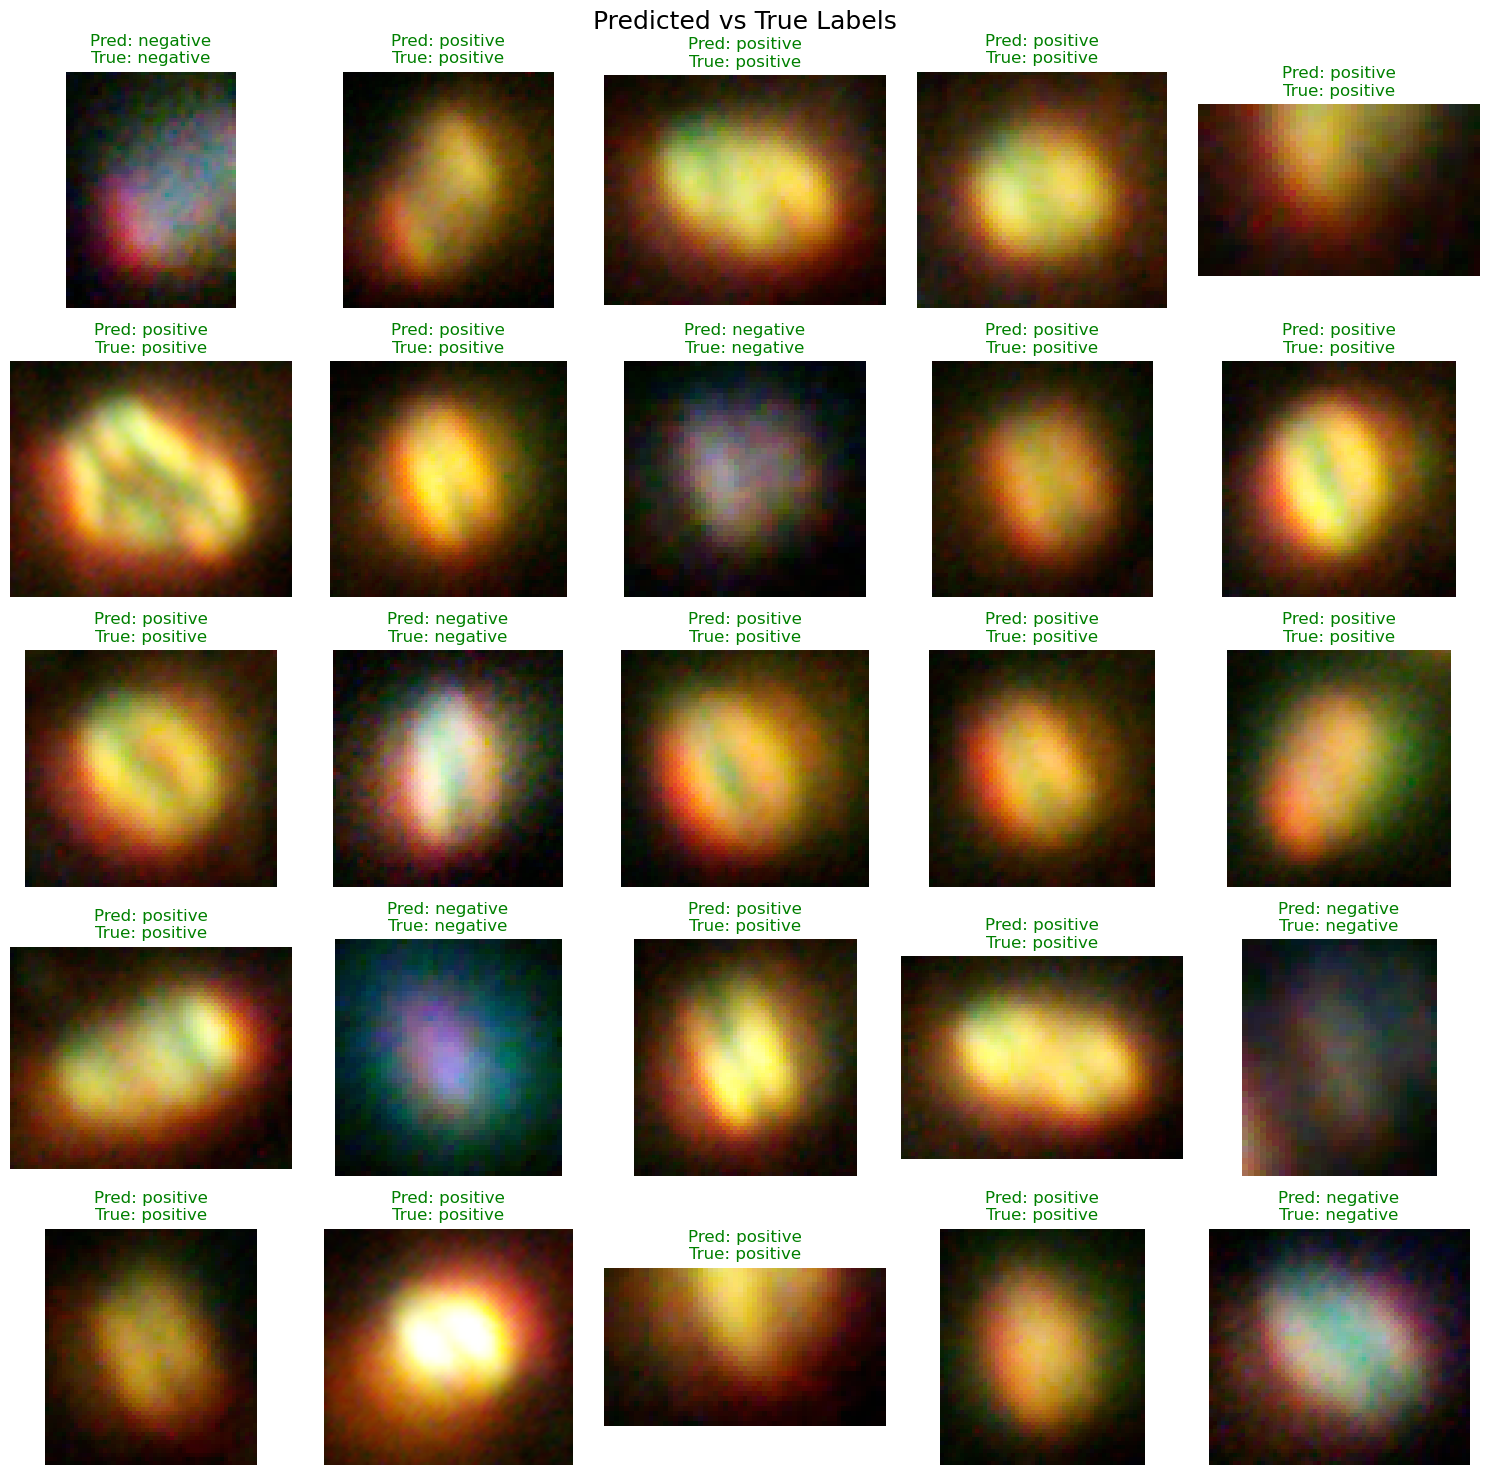

In [3]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
from PIL import Image
import os

# ======== CONFIG ========
MODEL_PATH = 'C:/Users/pc/Desktop/Attention/densenet169_2class.pth'
TEST_DIR = 'C:/Users/pc/Desktop/Attention/dataset_split/test'
IMG_SIZE = 96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== MODEL ========
from torchvision import models
import torch.nn as nn

class DenseNet169_Binary(nn.Module):
    def __init__(self):
        super(DenseNet169_Binary, self).__init__()
        self.backbone = models.densenet169(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.backbone(x)

model = DenseNet169_Binary().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ======== TRANSFORM ========
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ======== LOAD TEST DATA ========
label_map = {'negative': 0, 'positive': 1}
reverse_label_map = {v: k for k, v in label_map.items()}
samples = []
for label_name in label_map:
    folder = os.path.join(TEST_DIR, label_name)
    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        samples.append((path, label_map[label_name]))

# ======== EVALUATE ========
y_true = []
y_pred = []

with torch.no_grad():
    for path, label in samples:
        image = Image.open(path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        y_true.append(label)
        y_pred.append(predicted.item())

print("✅ Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ======== VISUALIZE 25 RANDOM TEST IMAGES ========
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Predicted vs True Labels", fontsize=18)

chosen_samples = random.sample(samples, 25)

for idx, (path, true_label) in enumerate(chosen_samples):
    image = Image.open(path).convert("RGB")
    display_img = image.copy()  # untransformed
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    pred_label = predicted.item()
    label_text = f"Pred: {reverse_label_map[pred_label]}\nTrue: {reverse_label_map[true_label]}"
    axs[idx // 5, idx % 5].imshow(display_img)
    axs[idx // 5, idx % 5].set_title(label_text, color="green" if pred_label == true_label else "red")
    axs[idx // 5, idx % 5].axis("off")

plt.tight_layout()
plt.show()
